# Zero Shot Learning

####   Dataset extraido de https://cvml.ist.ac.at/AwA2/?ref=https://githubhelp.com

In [66]:
#Dataset
import pandas as pd
df = pd.read_csv(
    'Animals_with_Attributes2/classes.txt', sep="\t",header=None)
df=df.drop([0], axis=1)
print(df)

                  1
0          antelope
1      grizzly+bear
2      killer+whale
3            beaver
4         dalmatian
5       persian+cat
6             horse
7   german+shepherd
8        blue+whale
9       siamese+cat
10            skunk
11             mole
12            tiger
13     hippopotamus
14          leopard
15            moose
16    spider+monkey
17   humpback+whale
18         elephant
19          gorilla
20               ox
21              fox
22            sheep
23             seal
24       chimpanzee
25          hamster
26         squirrel
27       rhinoceros
28           rabbit
29              bat
30          giraffe
31             wolf
32        chihuahua
33              rat
34           weasel
35            otter
36          buffalo
37            zebra
38      giant+panda
39             deer
40           bobcat
41              pig
42             lion
43            mouse
44       polar+bear
45           collie
46           walrus
47          raccoon
48              cow


# Data - Training

In [24]:
#Dataset-clases de entrenamiento
import pandas as pd
df = pd.read_csv(
    'Animals_with_Attributes2/trainclasses.txt',header=None)
#df=df.drop([0], axis=1)
print(df)

                  0
0          antelope
1      grizzly+bear
2      killer+whale
3            beaver
4         dalmatian
5             horse
6   german+shepherd
7        blue+whale
8       siamese+cat
9             skunk
10             mole
11            tiger
12            moose
13    spider+monkey
14         elephant
15          gorilla
16               ox
17              fox
18            sheep
19          hamster
20         squirrel
21       rhinoceros
22           rabbit
23              bat
24          giraffe
25             wolf
26        chihuahua
27           weasel
28            otter
29          buffalo
30            zebra
31             deer
32           bobcat
33             lion
34            mouse
35       polar+bear
36           collie
37           walrus
38              cow
39          dolphin


# Data - Zero Shot Learning

In [23]:
#Dataset-clases de prueba
import pandas as pd
df = pd.read_csv(
    'Animals_with_Attributes2/testclasses.txt',header=None)
print(df)

                0
0      chimpanzee
1     giant+panda
2         leopard
3     persian+cat
4             pig
5    hippopotamus
6  humpback+whale
7         raccoon
8             rat
9            seal


# Atributos de clase

In [34]:
#Caracteristicas de cada clase
import pandas as pd
df = pd.read_csv(
    'Animals_with_Attributes2/predicates.txt', sep="\t",header=None)
df=df.drop([0], axis=1)
print(df)
print("Cantidad de atributos de cada clase: ",len(df))

           1
0      black
1      white
2       blue
3      brown
4       gray
..       ...
80     smart
81     group
82  solitary
83  nestspot
84  domestic

[85 rows x 1 columns]
Cantidad de atributos de cada clase:  85


# Relacion de clases-atributos

Relación de clases y atributos


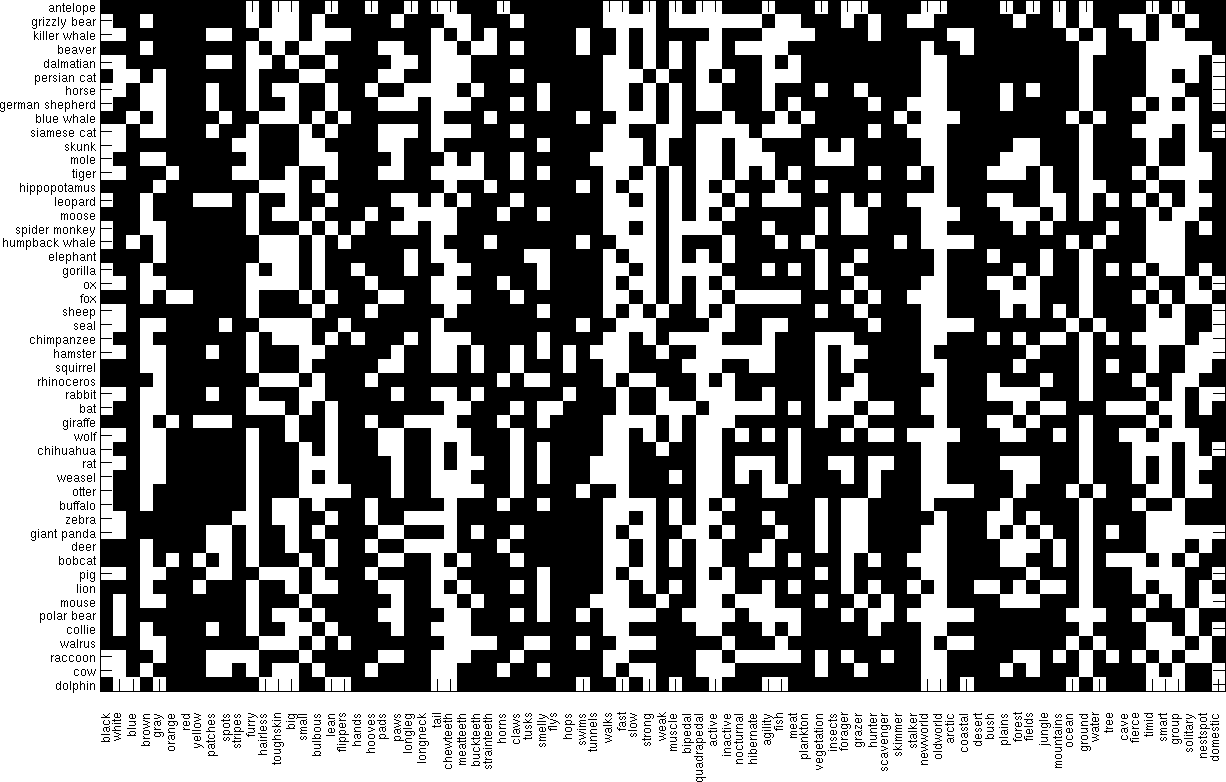

In [37]:
print("Relación de clases y atributos")
from IPython.display import Image
Image("Animals_with_Attributes2/predicate-matrix.png")

#![title](Animals_with_Attributes2/predicate-matrix.png)

# Preprocesamiento

In [86]:
import argparse
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import copy
import torch
import torch.nn as nn
import torchvision
from torch.utils import data
import torchvision.transforms as transforms
from torchvision import datasets, models
import os
import sys

In [58]:
#Preprocesamiento de la imagen para data de prueba y entrenamiento


train_dataset = datasets.ImageFolder('Animals_with_Attributes2/JPEGImages/train',
                              transform=transforms.Compose([
                                  #transforms.RandomResizedCrop(224),
                                  transforms.Resize(255),#dimensionamiento de la imagen
                                  transforms.CenterCrop(224),#corte de 224x224
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])
                                  ]))

test_dataset = datasets.ImageFolder('Animals_with_Attributes2/JPEGImages/test',
                              transform=transforms.Compose([
                                  #transforms.RandomResizedCrop(224),
                                  transforms.Resize(255),#dimensionamiento de la imagen
                                  transforms.CenterCrop(224),#corte de 224x224
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])
                                  ]))

class_names_train = train_dataset.classes
print(class_names_train)
class_names_test = test_dataset.classes
print(class_names_test)

['antelope', 'bat', 'beaver', 'blue+whale', 'bobcat', 'buffalo', 'chihuahua', 'collie', 'cow', 'dalmatian', 'deer', 'dolphin', 'elephant', 'fox', 'german+shepherd', 'giraffe', 'gorilla', 'grizzly+bear', 'hamster', 'horse', 'killer+whale', 'lion', 'mole', 'moose', 'mouse', 'otter', 'ox', 'polar+bear', 'rabbit', 'rhinoceros', 'sheep', 'siamese+cat', 'skunk', 'spider+monkey', 'squirrel', 'tiger', 'walrus', 'weasel', 'wolf', 'zebra']
['chimpanzee', 'giant+panda', 'hippopotamus', 'humpback+whale', 'leopard', 'persian+cat', 'pig', 'raccoon', 'rat', 'seal']


In [62]:
# Particionamos los subconjuntos en minibatches
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)#4 imagenes cada imagen, TRue random cada minibatch 
valid_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

In [63]:
#Escogemo el dispositivo cpu o gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/ninja/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [87]:
# Función de entrenamiento y validación
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  rs = '------------------------------------------------------------------'
  print('Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best')
  print(rs)
  
  for epoch in range(num_epochs):
    #print(f'Epoch {epoch}/{num_epochs-1}')
    #print('-' * 10)
    
    # Entrenamiento
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
        
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
    
    result = {}
    result['train_loss'] = running_loss /len(train_dataset)
    result['train_acc'] = running_corrects.double() / len(train_dataset)
      
    #print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    scheduler.step()
    
    # Validación 
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    result['val_loss'] = running_loss /len(test_dataset)
    result['val_acc'] = running_corrects.double() / len(test_dataset)
    epoch_acc = result['val_acc']
      
    #print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    st = '          '
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      st = '   ***    '
        
    print("%5d %11.4f %11.4f %11.4f %11.4f %s" % (epoch, result['train_loss'], result['train_acc'], result['val_acc'], result['val_acc'], st))

  print(rs)
  
  

  model.load_state_dict(best_model_wts)
  return model

# Definicion del modelo - Feature extraction

Eliminaremos la ultima capa del modelo resnet, para pasar las caracteristicas por una funcion lamda

In [77]:
#Importamos un modelo previamente entrenado
ft_model = models.resnet18(pretrained=True)

#Mantenemos fijo la parte convolucional
for param in ft_model.parameters():
    param.requires_grad = False
    
del ft_model.fc
ft_model.fc=lambda x:x

#Veamos la composicion del modelo resnet
#model.eval()

#Veamos la composicion del modelo resnet modificado, notaremos que no cuanta con la capa fully conected
ft_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [78]:
#Enviando el modelo al dispositivo
ft_model = ft_model.to(device)
ft_criterion = nn.CrossEntropyLoss()
ft_optimizer = torch.optim.SGD(ft_model.parameters(), lr=0.001, momentum=0.9)
ft_scheduler = torch.optim.lr_scheduler.StepLR(ft_optimizer, step_size=7, gamma=0.1)

In [89]:
# Entrenamiento
ft_model = train_model(ft_model, ft_criterion, ft_optimizer, ft_scheduler, num_epochs=25)

# Prediccion de dataset de zero shot learning

# Evaluacion de modelo

In [88]:
def get_hamming_dist(clase_actual, clase):
  return np.sum(clase_actual != clase)

def get_cosine_dist(clase_actual, clase):
  return np.sum(clase_actual * clase) / np.sqrt(np.sum(curr_labels)) / np.sqrt(np.sum(clase))

def get_euclidean_dist(clase_actual, clase):
  return np.sqrt(np.sum((clase_actual - clase)**2))
